In [2]:
import torch
from utility import image_util
import os
from voc12 import my_dataloader
from torch.utils.data import DataLoader
from misc import imutils
import numpy as np
import importlib

In [10]:
img_name_list_path = "voc12/val.txt"
voc12_root = "../Dataset/VOC2012/"
cam_root = "../irn_result/cam"
depth_root = "../result/depth_img/"
img_root = "../Dataset/VOC2012/JPEGImages/"

sem_seg_root = "../irn_result/sem_seg"
depth_sem_seg_root = "../irn_result/depth_crop_sem_seg/"
gt_root = "../Dataset/VOC2012/SegmentationClass"


In [204]:
img_name_list = my_dataloader.load_img_id_list(img_name_list_path)

idx = 189
name = img_name_list[idx]
cam_dict = np.load(os.path.join(cam_root, name +".npy"), allow_pickle=True).item()
cams = cam_dict['high_res']
org_img = image_util.read_image(os.path.join(img_root, name + ".jpg"))
seg_img = image_util.read_image(os.path.join(sem_seg_root, name + ".png"))
gt_img = image_util.read_image(os.path.join(gt_root, name + ".png"))
depth_seg_img = image_util.read_image(os.path.join(depth_sem_seg_root, name + ".png"))


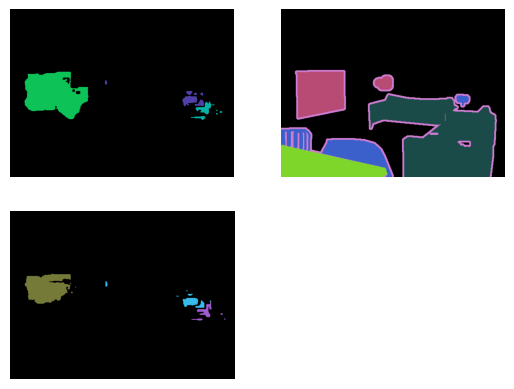

In [205]:
seg_img = image_util.random_color_mask(seg_img)
gt_img = image_util.random_color_mask(gt_img)
depth_seg_img = image_util.random_color_mask(depth_seg_img)

image_util.image_show(seg_img, gt_img, depth_seg_img, idx = (2, 2))
